In [2]:
import geopandas
import rioxarray
import pathlib
import matplotlib
import numpy
import shapely
import scipy.spatial
import xarray
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

Load in files - note using REC2.4 only because Ude used this when deriving population and slope over catchment patches. In future we should be using REC2.5

In [4]:
base_path = pathlib.Path(r"C:\Users\pearsonra\Documents\data\river_bathemetry")
rec2 = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\rec_domains\rec2_4\rec2_rivers.shp")
#dn3 = geopandas.read_file(r"")
domains = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\rec_domains\rec2_4\super_domains_sort_traces.gpkg")
waikanae_lower_catchment = geopandas.read_file(
    r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\small_waikanae.shp")
westport_catchment = geopandas.read_file(
    r"C:\Users\pearsonra\Documents\data\Westport\catchments\Rough_Catchment_outline\Rough_Catchment_outline.zip")

Specify relevant fids

In [3]:
domain_waikanae_fid = 65 # minus one from that specified in QGIS
domain_westport_fid = 102 # minus one from that specified in QGIS
rec2_waikanae_id = 9253579
rec2_westport_id = 12035600

In [253]:
#domains.iloc[domain_westport_fid]['geometry']

Cycle through the nodes from the initial ID using the NextDownID that matches the earch above and putting into a list. This can become a new GeoPandasDataframe of all polylines in a from coast to the upper catchment.

## A function to extract all polylines associated with a river

In [6]:
rec2.columns

Index(['HydroID', 'NextDownID', 'CATAREA', 'CUM_AREA', 'nzsegment', 'Enabled',
       'LENGTHDOWN', 'Headwater', 'Hydseq', 'StreamOrde', 'euclid_dis',
       'upElev', 'downElev', 'upcoordX', 'downcoordX', 'downcoordY',
       'upcoordY', 'sinuosity', 'nzreach_re', 'headw_dist', 'segslpmax',
       'segslpmean', 'LID', 'reachtype', 'FROM_NODE', 'TO_NODE', 'Shape_Leng',
       'geometry'],
      dtype='object')

In [10]:
def get_down_stream_reaches(rec: geopandas.GeoDataFrame, reach_id: int, reaches: geopandas.GeoDataFrame, i: int):
    if i>8000:
        print(f"Reached recursion limit at: {i}")
        return reaches, i
    i += 1
    down_stream_reaches = rec[rec['NextDownID']==reach_id]
    reaches = reaches.append(down_stream_reaches)
    for index, down_stream_reach in down_stream_reaches.iterrows():
        if not down_stream_reach['Headwater']: 
            reaches, i = get_down_stream_reaches(rec=rec, reach_id=down_stream_reach['nzsegment'], reaches=reaches, i=i)
    
    return reaches, i

## Generate shape files for the Waikanae river

<AxesSubplot:>

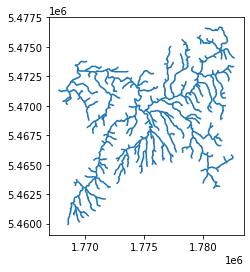

In [754]:
area_threshold = 100_000_000 # 10_000_000. 100_000_000
waikanae_river = rec2[rec2['nzsegment']==rec2_waikanae_id]
waikanae_river, i = get_down_stream_reaches(rec2, rec2_waikanae_id, waikanae_river, i=0)
waikanae_river.plot()

### Extract flat region

In [35]:
flat_waikanae_river = waikanae_river.clip(domains.iloc[domain_waikanae_fid]['geometry'], keep_geom_type=True)

In [36]:
flat_waikanae_river_polygon = geopandas.GeoDataFrame(geometry=flat_waikanae_river.buffer(150))
flat_waikanae_river_polygon['label'] = 1
flat_waikanae_river_polygon = flat_waikanae_river_polygon.dissolve(by='label')

<AxesSubplot:>

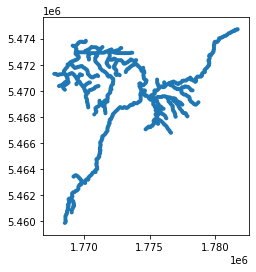

In [37]:
flat_waikanae_river_polygon.plot()

### Extract flat region above area threshold
Extract teh flat reaches with more upstream area than the set threshold

<AxesSubplot:>

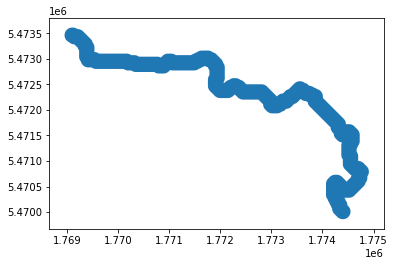

In [757]:
flat_waikanae_river_area = waikanae_river[waikanae_river['CUM_AREA']>area_threshold]
flat_waikanae_river_area_polygon = geopandas.GeoDataFrame(geometry=flat_waikanae_river_area.buffer(150))
flat_waikanae_river_area_polygon['label'] = 1
flat_waikanae_river_area_polygon = flat_waikanae_river_area_polygon.dissolve(by='label')
flat_waikanae_river_area_polygon.plot()

<AxesSubplot:>

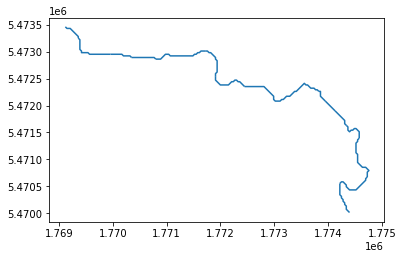

In [758]:
flat_waikanae_river_area.plot()

### Save out Waikanae river shapefiles

In [39]:
#waikanae_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_polyline.geojson")
#flat_waikanae_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_flat_polyline.geojson")
#flat_waikanae_river_polygon.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_flat_polygon.geojson")
flat_waikanae_river_area_polygon.to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_polygon_{area_threshold}.geojson")

## Generate shape files for the Westport river

In [49]:
area_threshold = 10_000_000 # 10_000_000. 100_000_000
westport_river = rec2[rec2['nzsegment']==rec2_westport_id]
westport_river, i = get_down_stream_reaches(rec2, rec2_westport_id, westport_river, i=0)
#westport_river.plot()

In [50]:
flat_westport_river = westport_river.clip(domains.iloc[domain_westport_fid]['geometry'], keep_geom_type=True)
#flat_westport_river.plot()

### Create flat polygon

In [163]:
flat_westport_river_polygon = geopandas.GeoDataFrame(geometry=flat_westport_river.buffer(300))
flat_westport_river_polygon['label'] = 1
flat_westport_river_polygon = flat_westport_river_polygon.dissolve(by='label')
# flat_westport_river_polygon.plot()

### Extract flat region above area threshold
Extract the flat reaches with more upstream area than the set threshold

<AxesSubplot:>

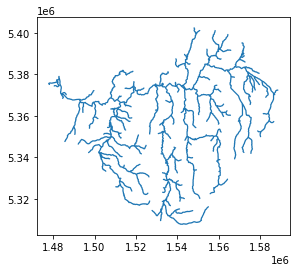

In [51]:
flat_westport_river_area = flat_westport_river[flat_westport_river['CUM_AREA']>area_threshold]
flat_westport_river_area_polygon = geopandas.GeoDataFrame(geometry=flat_westport_river_area.buffer(300))
flat_westport_river_area_polygon['label'] = 1
flat_westport_river_area_polygon = flat_westport_river_area_polygon.dissolve(by='label')
#flat_westport_river_area_polygon.plot()

<AxesSubplot:>

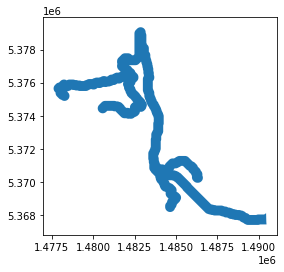

In [52]:
flat_westport_river_area_polygon_in_catchment = flat_westport_river_area_polygon.clip(westport_catchment, keep_geom_type=True)
flat_westport_river_area_polygon_in_catchment.plot()

### Save out Westport river files

In [53]:
#westport_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\westport_polyline.geojson")
#flat_westport_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\westport_flat_polyline.geojson")
#flat_westport_river_polygon.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\westport\westport_flat_polygon.geojson")
flat_westport_river_area_polygon_in_catchment.to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\westport\westport_polygon_{area_threshold}.geojson")

# Separate out River - edge detection - after manual placement of river in QGIS based of DEM & satallite
At polyline nodes - calculate perpindicular transect - look at slope change along this - cell to cell & slope change
* calculate width
* calculate avg elevation of 'river' bit

In [395]:
transect_length = 100 # in both directions
resolution = 1
sampling_resolution = 10 # transect spacing up river

## Waikanae

In [136]:
waikanae_manual_rivers = geopandas.read_file(base_path / "waikanae\manual_river_centre_100000000\manual_river_centre_100000000.geojson")
with rioxarray.rioxarray.open_rasterio(base_path / r"waikanae\clipped\results\1m_100000000_gnd.nc", masked=True) as waikane_dem:
            waikane_dem.load()
with rioxarray.rioxarray.open_rasterio(base_path / r"waikanae\clipped\results\1m_100000000_gnd_linear.nc", masked=True) as waikane_dem_linear:
            waikane_dem_linear.load()

### Get perpindicular sample lines from manual rivers
### Subsample every ten metres

In [445]:
def subsample_channels(channel_centre_lines: geopandas.GeoDataFrame, channel_id: int, sampling_resolution: float):
    line_string = channel_centre_lines.loc[channel_id]['geometry']
    sampled_channel_centre_lines = geopandas.GeoDataFrame({'id': [channel_id], 'geometry': shapely.geometry.LineString(
        [channel_centre_lines.loc[channel_id]['geometry'].interpolate(i * sampling_resolution) for i in range(int(numpy.ceil(channel_centre_lines.loc[channel_id]['geometry'].length/sampling_resolution)))])},
                                                          crs = channel_centre_lines.crs)
    return sampled_channel_centre_lines

In [446]:
sampled_waikanae_manual_rivers=subsample_channels(waikanae_manual_rivers, 0, sampling_resolution)

In [447]:
waikanae_manual_rivers.length

0    9663.404412
dtype: float64

### Sample elevations along main channel

In [448]:
def transects_along_reaches(channel_centre_lines: geopandas.GeoDataFrame, channel_id: int, transect_length: float):
    transects = {'geometry':[], 'nx':[], 'ny':[], 'midpoint': [], 'length': []}
    (x_array, y_array) = channel_centre_lines.loc[channel_id].geometry.xy
    for i in range(len(x_array)-1):
        # calculate midpoint
        midpoint = [(x_array[i] + x_array[i+1])/2, (y_array[i] + y_array[i+1])/2]

        # caclulate slope along segment
        dx = (x_array[i+1] - x_array[i])/numpy.sqrt((x_array[i+1] - x_array[i])**2 + (y_array[i+1] - y_array[i])**2)
        dy = (y_array[i+1] - y_array[i])/numpy.sqrt((x_array[i+1] - x_array[i])**2 + (y_array[i+1] - y_array[i])**2)
        
        # record nirmal to a segment nx and ny
        transects['nx'].append(-dy)
        transects['ny'].append(dx)

        # calculate transect - using effectively nx and ny
        transects['geometry'].append(shapely.geometry.LineString([[midpoint[0] + transect_length * dy, midpoint[1] - transect_length * dx],
                                                      midpoint,
                                                      [midpoint[0] - transect_length * dy, midpoint[1] + transect_length * dx]]))
        transects['midpoint'].append(shapely.geometry.Point(midpoint))
        # record the length of the line segment
        transects['length'].append(numpy.sqrt((x_array[i+1]-x_array[i])**2 + (y_array[i+1] - y_array[i])**2))
    transects = geopandas.GeoDataFrame(transects, crs=channel_centre_lines.crs) 
    return transects

In [450]:
transects = transects_along_reaches(sampled_waikanae_manual_rivers, 0, transect_length)

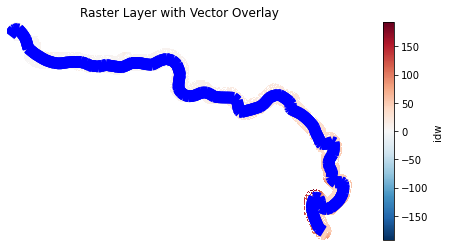

In [452]:
f, ax = matplotlib.pyplot.subplots(figsize=(11, 4))

waikane_dem.plot(ax=ax)

waikanae_manual_rivers[waikanae_manual_rivers['id']==0].plot(color='green', linewidth=3, ax=ax)

transects.plot(color='blue',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
matplotlib.pyplot.show()

### Sample elevations along each transect at the resolution

In [500]:
def sample_from_transects(transects: geopandas.GeoDataFrame, dem: xarray.core.dataarray.DataArray, transect_length: float, resolution: float):
    
    # number of transect samples - ensure be odd
    number_of_samples = int(numpy.floor(transect_length/resolution) * 2 - 1)
    sample_index_array = numpy.arange(-numpy.floor(number_of_samples/2), numpy.floor(number_of_samples/2) + 1, 1)
    
    transect_samples = {'elevations': [], 'xx': [], 'yy': [], 'min_z':[]}
    
    # create tree to sample from
    grid_x, grid_y = numpy.meshgrid(dem.x, dem.y)
    xy_in = numpy.concatenate([[grid_x.flatten()], [grid_y.flatten()]], axis=0).transpose()
    tree = scipy.spatial.KDTree(xy_in)
    
    # cycle through each transect - calculate sample points then look up
    for index, row in transects.iterrows():
        #calculate xx, and yy points to sample at
        if row['nx'] == 0:
            xx=row.midpoint.x + numpy.zeros(number_of_samples)
        else:
            xx=row.midpoint.x + sample_index_array * resolution * row['nx']
        if row['ny'] == 0:
            yy=row.midpoint.y + numpy.zeros(number_of_samples)
        else:
            yy=row.midpoint.y + sample_index_array * resolution * row['ny']
        
        # Sample the elevations at along the transect
        xy_points = numpy.concatenate([[xx], [yy]], axis=0).transpose()
        assert len(xy_points) == 199, f"{len(xx)}, {len(yy)}, {len(xy_points)}, {row['nx']}, {row['ny']}"
        distances, indices = tree.query(xy_points)
        elevations = dem.data.flatten()[indices]
        transect_samples['elevations'].append(elevations)
        transect_samples['min_z'].append(numpy.nanmin(elevations))
    
    return transect_samples

In [568]:
numpy.argmin([1,2,3, numpy.nan])

3

In [503]:
transect_samples = sample_from_transects(transects, waikane_dem, transect_length, resolution)
transect_samples_linear = sample_from_transects(transects, waikane_dem_linear, transect_length, resolution)

### Plot transect elevations

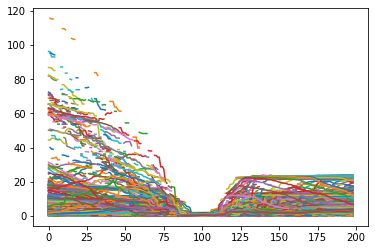

In [504]:
for elevations, min_z in zip(transect_samples['elevations'], transect_samples['min_z']):
    matplotlib.pyplot.plot(elevations - min_z)

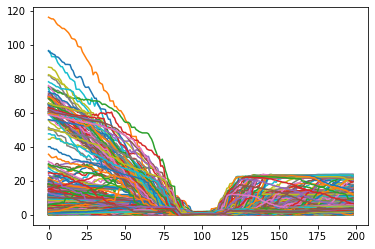

In [505]:
for elevations, min_z in zip(transect_samples_linear['elevations'], transect_samples_linear['min_z']):
    matplotlib.pyplot.plot(elevations - min_z)

# Calculate width and slope
Use the linear interpolation as we have results everywhere

In [597]:
def width_from_samples(transects: geopandas.GeoDataFrame, transect_samples: dict, threshold: float, resolution: float):
    
    widths = {'widths': [], 'first_widths': [], 'last_widths': []}
    
    for j in range(len(transect_samples['elevations'])):
    
        assert numpy.floor(len(transect_samples['elevations'][j])/2) != len(transect_samples['elevations'][j])/2, "Expect an odd length"
        start_i = numpy.nan
        stop_i = numpy.nan
        centre_index = int(numpy.floor(len(transect_samples['elevations'][j])/2))
        
        for i in numpy.arange(0, centre_index, 1):
            # work forward checking height
            if transect_samples['elevations'][j][centre_index + i] - transects.loc[j]['upstream_min_z'] > threshold and numpy.isnan(stop_i):
                stop_i = centre_index + i
            # work backward checking height
            if transect_samples['elevations'][j][centre_index - i] - transects.loc[j]['upstream_min_z'] > threshold and numpy.isnan(start_i):
                start_i = centre_index - i
        
        widths['first_widths'].append((centre_index-start_i)*resolution)
        widths['last_widths'].append((stop_i-centre_index)*resolution)
        widths['widths'].append((stop_i - start_i)*resolution)
    
    return widths

In [559]:
def width_from_samples_zeroed(transects: geopandas.GeoDataFrame, transect_samples: dict, threshold: float, resolution: float):
    
    widths = {'widths': [], 'first_widths': [], 'last_widths': []}
    
    for j in range(len(transect_samples['elevations'])):
        
        zeroed_elevations = transect_samples['elevations'][j]-transects.loc[j]['mean_min_z']
    
        assert numpy.floor(len(zeroed_elevations)/2) != len(zeroed_elevations)/2, "Expect an odd length"
        start_i = numpy.nan
        stop_i = numpy.nan
        centre_index = int(numpy.floor(len(zeroed_elevations)/2))
        
        for i in numpy.arange(0, centre_index, 1):
            # work forward checking height
            if zeroed_elevations[centre_index + i] - zeroed_elevations[centre_index] > threshold and numpy.isnan(stop_i):
                stop_i = centre_index + i
            # work backward checking height
            if zeroed_elevations[centre_index - i] - zeroed_elevations[centre_index] > threshold and numpy.isnan(start_i):
                start_i = centre_index - i
        
        widths['first_widths'].append((centre_index-start_i)*resolution)
        widths['last_widths'].append((stop_i-centre_index)*resolution)
        widths['widths'].append((stop_i - start_i)*resolution)
    
    return widths

Calculate the rolling average of minimum elevations - note same for samples and linear interpolated samples

In [578]:
transects['min_z'] = transect_samples['min_z']
transects['mean_min_z'] = transects['min_z'].rolling(5, center=True).mean()
transects.loc[numpy.isnan(transects['mean_min_z']), ('mean_min_z')] = transects['min_z'][numpy.isnan(transects['mean_min_z'])]

Calculate the minimum upstream river depth

In [594]:
min_z = transects['mean_min_z']
upstream_min_z = numpy.zeros(len(min_z))
upstream_min_z[-1] = min_z[len(min_z) - 1]
for i in range(len(min_z) - 2, -1, -1): # range [len-1, len-2, len-3, ..., 2, 1, 0]
    upstream_min_z[i] = min_z[i] if min_z[i] < upstream_min_z[i + 1] else upstream_min_z[i + 1]
transects['upstream_min_z'] = upstream_min_z

## Calculate widths

In [725]:
threshold = 1
widths_linear = width_from_samples(transects, transect_samples_linear, threshold, resolution)
widths = width_from_samples(transects, transect_samples, threshold, resolution)

In [726]:
widths_input = widths

In [727]:
def apply_bank_width(midpoint, nx, ny, first_widths, last_widths):
    
    return shapely.geometry.LineString([[midpoint.x - first_widths * nx, midpoint.y - first_widths * ny],
                                                      midpoint,
                                                      [midpoint.x + last_widths * nx, midpoint.y + last_widths * ny]])

In [728]:
transects['width'] = widths_input['widths']
transects['first_widths'] = widths_input['first_widths']
transects['last_widths'] = widths_input['last_widths']
transects['slope'] = transects['upstream_min_z'].diff()/transects['length']
transects['width_line'] = transects.apply(lambda x: apply_bank_width(x['midpoint'], x['nx'], x['ny'], x['first_widths'], x['last_widths']), axis=1)

In [729]:
transects.loc[transects['width']==0, ('width')] = numpy.nan

In [730]:
display_line_widths = geopandas.GeoDataFrame(geometry=transects['width_line'][~numpy.isnan(transects['width'])], crs=transects.crs)

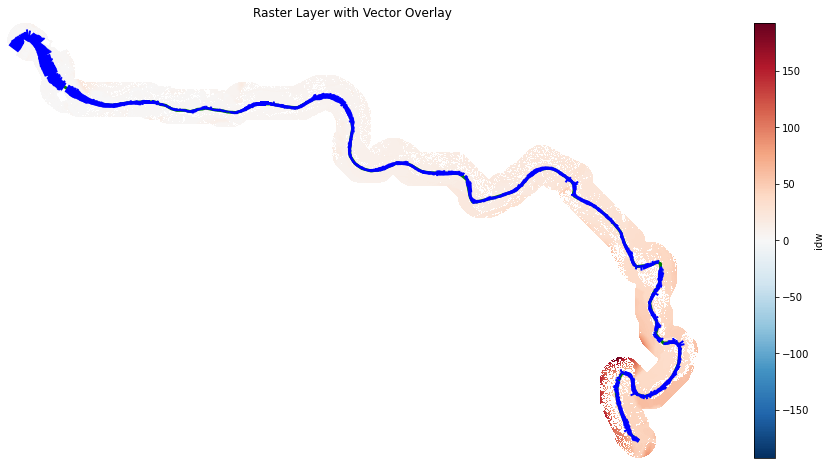

In [731]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))

waikane_dem.plot(ax=ax)

waikanae_manual_rivers[waikanae_manual_rivers['id']==0].plot(color='green', linewidth=3, ax=ax)

display_line_widths.plot(color='blue',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
matplotlib.pyplot.show()

### Save out results
* Table: 10m spaced width, height and slope values along the reach - alongside the midpoint values
* Plot: width as a line over the LiDAR - will need the midpoint, nx, ny, and start and stop indices

In [732]:
transects.drop(columns=['midpoint', 'width_line']).to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_trasects_mean_depth_{sampling_resolution}m_downriver_{threshold}m_bank_thresh_upstream_linear.geojson")
display_line_widths.to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_width_mean_depth_{sampling_resolution}m_downriver_{threshold}m_bank_thresh_upstream_linear.geojson")

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\pearsonra\\Documents\\data\\river_bathemetry\\waikanae\\waikanae_width_mean_depth_10m_downriver_1m_bank_thresh_upstream_linear.geojson'

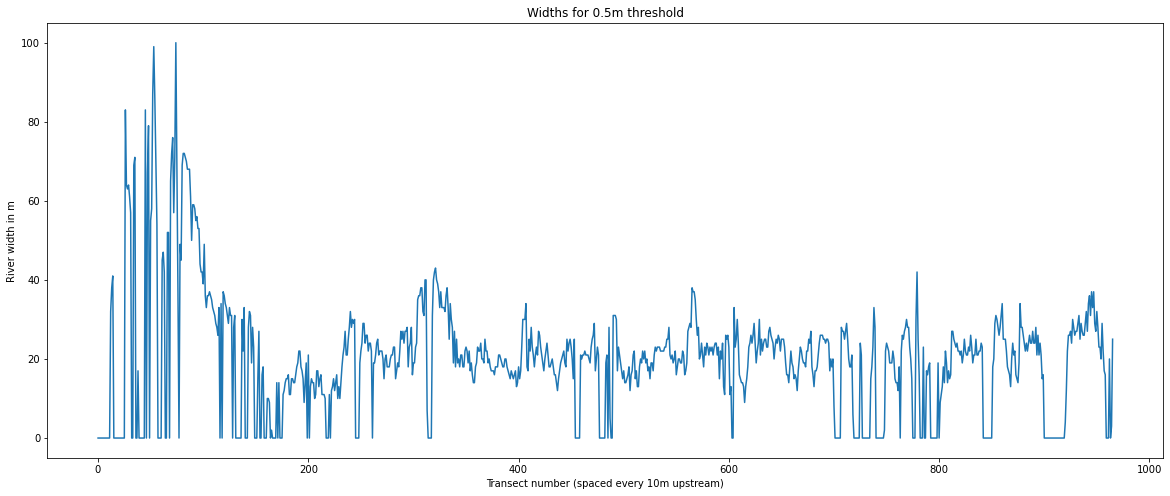

In [641]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))
transects['width'].plot(ax=ax)
ax.set(title=f"Widths for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width in m");

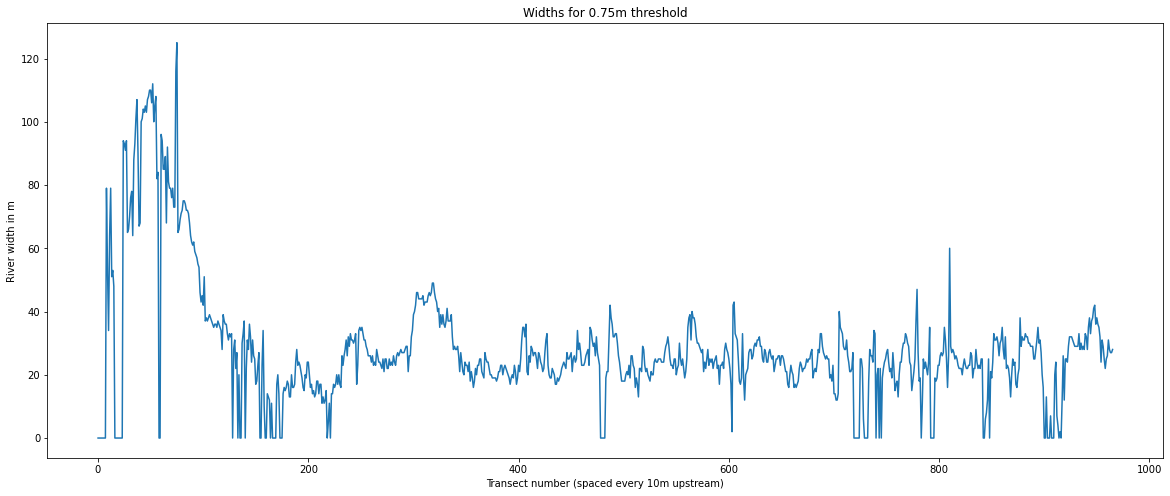

In [649]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))
transects['width'].plot(ax=ax)
ax.set(title=f"Widths for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width in m");

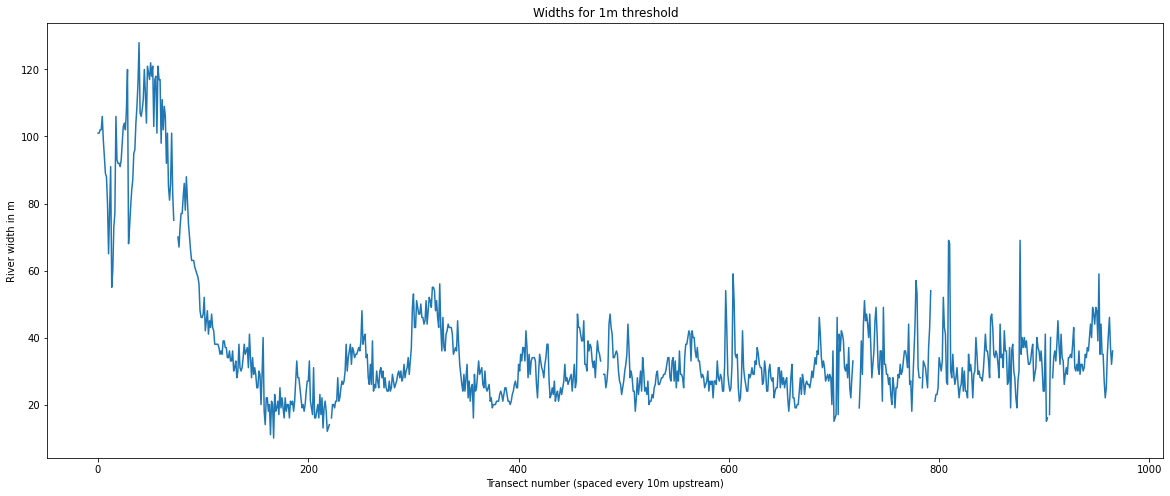

In [689]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))
transects['width'].plot(ax=ax)
ax.set(title=f"Widths for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width in m");

## Plot width on line plot with elevation transect

## Plot bank locations alongside transects on DEM in plan view

## Save out river bank points or width lines

In [744]:
flat_waikanae_river_area.head(5)

,HydroID,NextDownID,CATAREA,CUM_AREA,nzsegment,Enabled,LENGTHDOWN,Headwater,Hydseq,StreamOrde,...,nzreach_re,headw_dist,segslpmax,segslpmean,LID,reachtype,FROM_NODE,TO_NODE,Shape_Leng,geometry
254402,253496,0,18001.0,152753696.0,9253579,1,0.000000,0,256825,5,...,9003742,24527,0.000000,0.000000,0,0,259082,259083,15.000400,"LINESTRING (1769118.631 5473462.110, 1769103.6..."
254357,253531,9253579,72004.1,151917552.0,9253587,1,15.000400,0,256824,5,...,9003756,24512,0.002054,0.000469,0,0,259120,259082,344.568295,"LINESTRING (1769358.632 5473252.097, 1769358.6..."
254240,253531,9253579,72004.1,151917552.0,9253587,1,15.000400,0,256824,5,...,9003756,24512,0.002054,0.000469,0,0,259120,259082,344.568295,"LINESTRING (1769166.129 5473432.108, 1769148.6..."
254181,253613,9253587,239414.0,142299648.0,9253625,1,359.568695,0,256823,5,...,9003855,24167,8.140000,3.140000,0,0,259213,259120,847.303839,"LINESTRING (1769958.641 5472952.071, 1769568.6..."
254124,253613,9253587,239414.0,142299648.0,9253625,1,359.568695,0,256823,5,...,9003855,24167,8.140000,3.140000,0,0,259213,259120,847.303839,"LINESTRING (1769506.183 5472982.085, 1769456.5..."


# Find which reach id a section intersects with

In [759]:
transects_to_matt = transects.drop(columns=['nx', 'ny', 'length', 'min_z', 'first_widths', 'last_widths', 'width_line', 'mean_min_z', 'upstream_min_z'])
transects_to_matt['nzsegment'] = numpy.zeros(len(transects_to_matt['width']), dtype=int) * -1
for i, row in flat_waikanae_river_area.iterrows():
    transects_to_matt.loc[transects_to_matt.intersects(row.geometry), ('nzsegment')] = row['nzsegment']

In [762]:
transects_to_matt.to_csv(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_river_widths_at_{sampling_resolution}m_upriver_spacing_{threshold}m_bank_threshold_upstream.csv")

In [761]:
transects_to_matt.drop(columns=['midpoint']).to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_river_widths_at_{sampling_resolution}m_upriver_spacing_{threshold}m_bank_threshold_upstream.geojson")

In [738]:
transects_to_matt

,geometry,midpoint,width,slope,nzsegment
0,"LINESTRING (1769085.690 5473338.758, 1769005.9...",POINT (1769005.949813478 5473399.101946687),101.0,NaN,0
1,"LINESTRING (1769091.725 5473346.732, 1769011.9...",POINT (1769011.98424018 5473407.076010544),101.0,0.000000,0
2,"LINESTRING (1769097.759 5473354.706, 1769018.0...",POINT (1769018.018666882 5473415.0500744),102.0,0.000000,0
3,"LINESTRING (1769103.794 5473362.680, 1769024.0...",POINT (1769024.053093584 5473423.024138256),102.0,0.000000,0
4,"LINESTRING (1769109.828 5473370.654, 1769030.0...",POINT (1769030.087520286 5473430.998202112),106.0,0.000000,0
...,...,...,...,...,...
961,"LINESTRING (1774298.361 5469959.534, 1774362.8...",POINT (1774362.860992278 5470035.952304416),41.0,0.000000,9254385
962,"LINESTRING (1774308.878 5469950.974, 1774370.6...",POINT (1774370.607623319 5470029.647040658),46.0,0.006682,9254385
963,"LINESTRING (1774326.315 5469938.817, 1774378.7...",POINT (1774378.789625351 5470023.943031995),37.0,0.000000,9254385
964,"LINESTRING (1774334.827 5469933.570, 1774387.3...",POINT (1774387.302202234 5470018.695553094),32.0,0.000000,9254385


<AxesSubplot:>

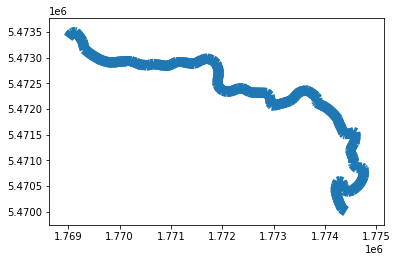

In [740]:
transects_to_matt.loc[transects_to_matt.intersects(flat_waikanae_river_area.iloc[].geometry), ('nzsegment')] = row['nzsegment']

In [763]:
flat_waikanae_river_area.head()

,HydroID,NextDownID,CATAREA,CUM_AREA,nzsegment,Enabled,LENGTHDOWN,Headwater,Hydseq,StreamOrde,...,nzreach_re,headw_dist,segslpmax,segslpmean,LID,reachtype,FROM_NODE,TO_NODE,Shape_Leng,geometry
253495,253496,0,18001.0,152753696.0,9253579,1,0.000000,0,256825,5,...,9003742,24527,0.000000,0.000000,0,0,259082,259083,15.000400,"LINESTRING (1769118.631 5473462.110, 1769103.6..."
253530,253531,9253579,72004.1,151917552.0,9253587,1,15.000400,0,256824,5,...,9003756,24512,0.002054,0.000469,0,0,259120,259082,344.568295,"LINESTRING (1769358.632 5473252.097, 1769358.6..."
253612,253613,9253587,239414.0,142299648.0,9253625,1,359.568695,0,256823,5,...,9003855,24167,8.140000,3.140000,0,0,259213,259120,847.303839,"LINESTRING (1769958.641 5472952.071, 1769568.6..."
253627,253628,9253625,112506.9,141125072.0,9253707,1,1206.872535,0,256822,5,...,9003869,23320,6.550000,2.700000,0,0,259228,259213,414.865601,"LINESTRING (1770348.651 5472892.057, 1770318.6..."
253638,253639,9253707,150309.7,140436528.0,9253724,1,1621.738136,0,256821,5,...,9003869,22905,1.010000,0.700000,0,0,259238,259228,462.441151,"LINESTRING (1770798.664 5472862.042, 1770768.6..."
